In [288]:
#Install dataset
!pip install astroquery

In [289]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [290]:
#Implementation cell
from sklearn.neighbors import NearestNeighbors


def calculateEpsilon(data, P, initialEpsilon, threshold):
    """
    Calculate dynamic epsilon for point P based on the density of the neighborhood.
    """
    neighbors = findNeighbors(data, P, initialEpsilon)
    density = len(neighbors)

    if density > threshold:
        epsilon = initialEpsilon * (threshold / density)
    else:
        epsilon = initialEpsilon
    return epsilon

def findNeighbors(data, P, epsilon):
    """
    Find all neighbors of point P within distance epsilon.
    """
    data_array = data.values if isinstance(data, pd.DataFrame) else data

    nbrs = NearestNeighbors(radius=epsilon).fit(data_array)
    indices = nbrs.radius_neighbors([data_array[P]], return_distance=False)[0]
    return list(indices)

def expandCluster(data, labels, P, neighbors, clusterID, epsilon, minSamples):
    """
    Expands a cluster starting from point P, checking its neighbors and iterating to expand the cluster.
    """
    labels[P] = clusterID
    pointsToCheck = neighbors.copy()

    while pointsToCheck:
        point = pointsToCheck.pop()

        if labels[point] == 0:
            epsilon = calculateEpsilon(data, point, epsilon, threshold=30)

            newNeighbors = findNeighbors(data, point, epsilon)

            if len(newNeighbors) >= minSamples:
                pointsToCheck.extend(newNeighbors)

        if labels[point] <= 0:
            labels[point] = clusterID

#Main DBSCAN function
def improvedDBSCAN(data, initialEpsilon, minSamples, threshold):
    labels = np.zeros(len(data))
    clusterID = 0

    for P in range(len(data)):
        if labels[P] != 0: 
            continue

        epsilon = calculateEpsilon(data, P, initialEpsilon, threshold)

        neighbors = findNeighbors(data, P, epsilon)

        if len(neighbors) < minSamples:
            labels[P] = -1
        else:
            clusterID += 1
            expandCluster(data, labels, P, neighbors, clusterID, epsilon, minSamples)

    return labels

In [291]:
#Data preparation for dataset #1 (Planets dataset)
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive

exoplanets = NasaExoplanetArchive.query_criteria(table="ps", select="pl_name, pl_orbper, pl_radj")
exoplanets_df = exoplanets.to_pandas()
data = exoplanets_df
data = data.dropna()

#Removing largest values from datasets, which skewed results
data = data[data['pl_orbper'] < data['pl_orbper'].nlargest(450).min()]
data = data[data['pl_radj'] < data['pl_radj'].nlargest(450).min()]

#Limit to 1000
data = data.iloc[:1000]
#Removing values again after data reduction
data = data[data['pl_orbper'] < data['pl_orbper'].nlargest(11).min()]
data = data[['pl_orbper', 'pl_radj']]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 989 entries, 0 to 1720
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pl_orbper  989 non-null    float64
 1   pl_radj    989 non-null    float64
dtypes: float64(2)
memory usage: 23.2 KB


In [292]:
from sklearn.preprocessing import StandardScaler

#Scaling features for DBSCAN
scaler = StandardScaler()
X = data[['pl_orbper', 'pl_radj']]
X_scaled = scaler.fit_transform(X) #commented out scaler 

X_scaled = pd.DataFrame(X_scaled, columns=['pl_orbper', 'pl_radj'])
X = X_scaled

In [293]:
from sklearn.cluster import DBSCAN
#Initialize the DBSCAN model
db = DBSCAN(eps=0.5, min_samples=12)

labels = db.fit_predict(X)
X['Cluster'] = labels
X.head()

,pl_orbper,pl_radj,Cluster
0,-0.528841,1.756817,0
1,-0.669765,-0.794334,0
2,-0.447877,-0.882227,0
3,-0.230095,-0.749261,0
4,0.246765,-0.575729,0


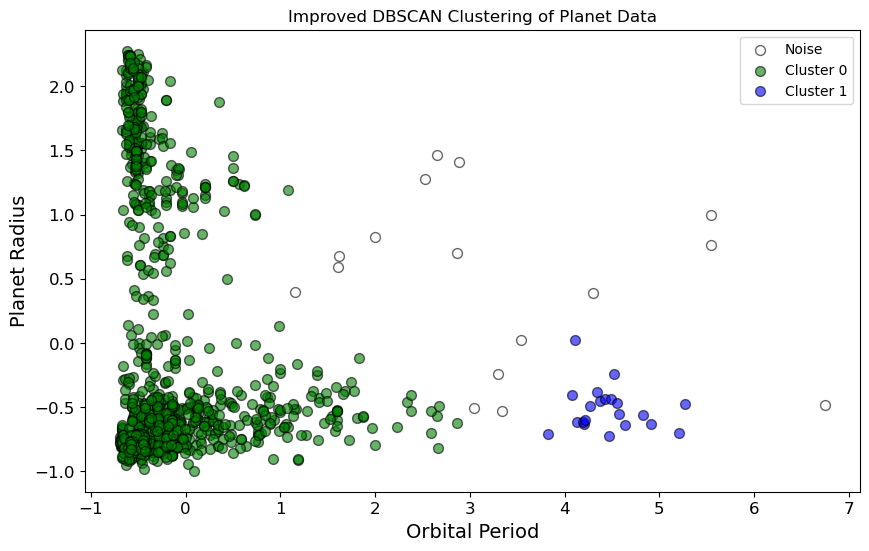

In [294]:
#Plot cell
unique_labels = X['Cluster'].unique()
num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  #Exclude noise if present
colors = {
    0: 'green', 1: 'blue', 2: 'lime', 3: 'purple', 4: 'orange', 5: 'magenta', 6: 'pink', 7: 'brown', 
    8: 'turquoise', 9: 'gold', 10: 'red', 11: 'cyan', 12: 'crimson', 13: 'violet', 14: 'indigo', 15: 'yellow'
}
handles = []
labels = []

#Plot each point with a color based on its cluster label
plt.figure(figsize=(10, 6))
for label in unique_labels:
    if label == -1:
        #Plot noise points in white
        scatter = plt.scatter(X[X['Cluster'] == label]['pl_orbper'], 
                    X[X['Cluster'] == label]['pl_radj'], 
                    c='white', label='Noise', s=50, marker='o', edgecolor='k', alpha=0.6)
    else:
        #Plot clusters with different colors
        color = colors.get(label, 'gray')
        scatter = plt.scatter(X[X['Cluster'] == label]['pl_orbper'], 
                    X[X['Cluster'] == label]['pl_radj'], 
                    color=color, label=f'Cluster {int(label)}', s=50, marker='o', edgecolor='k', alpha=0.6)

    handles.append(scatter)
    labels.append(label)

sorted_labels_and_handles = sorted(zip(labels, handles), key=lambda x: (x[0] != -1, x[0]))
sorted_labels, sorted_handles = zip(*sorted_labels_and_handles)
formatted_labels = ['Noise' if label == -1 else f'Cluster {int(label)}' for label in sorted_labels]

#Labeling the plot
plt.title("Improved DBSCAN Clustering of Planet Data")
plt.xlabel("Orbital Period")
plt.ylabel("Planet Radius")
plt.legend(handles=sorted_handles, labels=formatted_labels)
plt.show()